In [1]:
import numpy as np
from scipy.sparse import dok_matrix, csr_matrix
from math import log, sqrt
from scipy.linalg import expm
from scipy import sparse
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt
import numpy.ma as ma
from matplotlib.colors import ListedColormap, BoundaryNorm

Parameter

In [2]:
# Wright-Fisher parameters
N_pop = 10000          # Total population size
mutation_rate = 0.001  # Mutation rate
tau = 1000             # Total generations
dt = 1                 # Time step

# Drug fitness profiles
actions = [0, 1, 2, 3]  # Possible drug actions
drug_lists = {
    0: [0.993, 0.998, 1.009, 1.003],  # Drug A
    1: [1.005, 0.988, 0.999, 1.001],   # Drug B
    2: [0.997, 1.001, 0.989, 1.003],  # Drug C
    3: [0.995, 1.005, 1.002, 0.999]  # Drug D
}

# State Grid
L = 25               # Grid resolution
a = 1/L             
N_states = L * L * L     # Total number of states

states = [(a * (0.5 + i), a * (0.5 + j), a * (0.5 + k)) for k in range(L) for j in range(L) for i in range(L)]

Helper Function

In [3]:
def get_f(action):
    return drug_lists[action]

def get_s(action):
    f = get_f(action)
    s1 = f[1] / f[0] - 1
    s2 = f[2] / f[0] - 1
    s3 = f[3] / f[0] - 1
    return s1, s2, s3

def unpack(u):
    x1 = u[0]
    x2 = u[1] * (1 - x1)
    x3 = u[2] * (1 - u[0]) * (1 - u[1])
    x0 = 1 - x1 - x2 - x3
    return x0, x1, x2, x3

def normalize_eigenvector(eigenvector):
    """Normalize eigenvector to sum to 1 with positive values."""
    if np.all(eigenvector < 0):
        eigenvector = -eigenvector
    total_sum = np.sum(eigenvector)
    return eigenvector.real / total_sum

In [4]:
# Fokker-Planck
def A1(u, action):
    s1, s2, s3 = get_s(action)
    return mutation_rate*((1-u[0])*(1-u[1])-2*u[0]) + u[0]*(1-u[0])*(s1 - u[1]*s2 - (1-u[1])*u[2]*s3)

def A2(u, action):
    s1, s2, s3 = get_s(action)
    return mutation_rate/(1-u[0])*((1-u[0])*(1-u[1])*(1+u[1])-2*(1-u[0])*u[1]-2*u[0]*u[1]) + u[1]*(1-u[1])*(s2 - u[2]*s3)

def A3(u, action):
    s1, s2, s3 = get_s(action)
    return mutation_rate/((1-u[0])*(1-u[1]))*(u[0]+(1-u[0])*u[1])*(1-2*u[2]) + u[2]*(1-u[2])*s3

def D1(u):
    return u[0] * (1 - u[0]) / (2 * N_pop)

def D2(u):
    return u[1] * (1 - u[1]) / (2 * N_pop * (1 - u[0]))

def D3(u):
    return u[2] * (1 - u[2]) / (2 * N_pop * (1 - u[0])*(1 - u[1]))

In [5]:
# Discrete Markov Model
def build_transition_rate_matrix(action,states):
    
    Omega = dok_matrix((L*L*L, L*L*L), dtype=np.float64)

    # Loop over all states to define the off-diagonal rates.
    for n in range(N_states):
        u = states[n]

        # i, j, k coordinates of state n
        i = n % L
        j = (n // L) % L
        k = n // (L * L)

        # Right (i+1)
        if i < L - 1:
            m = n + 1
            rate = D1(u)/a**2 + A1(u, action)/(2*a)
            Omega[n, m] = rate

        # Left (i-1)
        if i > 0:
            m = n - 1
            rate = D1(u)/a**2 - A1(u, action)/(2*a)
            Omega[n, m] = rate

        # Up (j+1)
        if j < L - 1:
            m = n + L
            rate = D2(u)/a**2 + A2(u, action)/(2*a)
            Omega[n, m] = rate

        # Down (j-1)
        if j > 0:
            m = n - L
            rate = D2(u)/a**2 - A2(u, action)/(2*a)
            Omega[n, m] = rate

        # Front (k+1)
        if k < L - 1:
            m = n + L * L
            rate = D3(u)/a**2 + A3(u, action)/(2*a)
            Omega[n, m] = rate
            
        # Back neighbor:
        if k > 0:
            m = n - L * L
            rate = D3(u)/a**2 - A3(u, action)/(2*a)
            Omega[n, m] = rate

    # Set diagonal elements such that row sums are zero.
    for n in range(N_states):
        row_sum = Omega[n, :].sum()
        Omega[n, n] = -row_sum

    return Omega.tocsr()

def build_transition_matrix(transition_rate_matrix, dt):
    W = expm(transition_rate_matrix.toarray()*dt)
    W[W < 0] = 0.0                         # clip tiny negatives
    row_sums = W.sum(axis=1, keepdims=True)
    W = W / row_sums                       # renormalize rows
    return W

In [6]:
# MDP
def compute_reward(state, action):
    x0, x1, x2, x3 = unpack(state)
    f0, f1, f2, f3 = get_f(action)  
    fitness = x0*f0 + x1*f1 + x2*f2 +x3*f3
    return -fitness  # Negative reward to minimize fitness

def build_W_and_R(actions, states, dt):
    """Return P-list and R-matrix for all actions."""
    N_states = len(states)
    P = []
    R = np.zeros((N_states, len(actions)), dtype=np.float64)

    for a in actions:
        Omega   = build_transition_rate_matrix(a, states)
        W  = build_transition_matrix(Omega, dt)
        P.append(W)
        for i, s in enumerate(states):
            R[i, a] = compute_reward(s, a)
    return P, R

MDP solution

In [7]:
W, R = build_W_and_R(actions, states, dt)
vi = mdp.ValueIteration(transitions=W, reward=R, discount=0.99, epsilon=1e-4, max_iter=1000)
vi.run()

policy_grid = np.array(vi.policy).reshape((L, L, L)) #3D

In [32]:
# time vector
t_step = int(tau / dt)
t = np.linspace(0, tau, t_step + 1)

Wright-Fisher simulation

In [10]:
def pack(freq):
    x0, x1, x2, x3 = freq
    u1 = x1
    den1 = 1 - u1
    u2 = 0 if den1 == 0 else x2 / den1
    den2 = den1 * (1 - u2)
    u3 = 0 if den2 == 0 else x3 / den2
    return u1, u2, u3

In [11]:
num_genotypes = 4
genotypes = [format(i, f'0{int(np.log2(num_genotypes))}b') for i in range(num_genotypes)]

# map continuous freq→discrete index
def freq_to_state_idx(freq, L):
    u1, u2, u3 = pack(freq)
    # clip just in case numerical drift
    i = min(max(int(np.floor(u1 * L)), 0), L-1)
    j = min(max(int(np.floor(u2 * L)), 0), L-1)
    k = min(max(int(np.floor(u3 * L)), 0), L-1)
    return i + L*j + (L**2)*k

# single WF run given a drug‐picker
def mdp_picker(freq):
    idx = freq_to_state_idx(freq, L)
    return vi.policy[idx]

def run_wf(picker):
    # build symmetric mutation matrix Q (j→i)
    #Q = np.full((num_genotypes, num_genotypes), mutation_rate)
    #np.fill_diagonal(Q, 1 - mutation_rate*(num_genotypes - 1))

    # Mutation transition matrix Q_{ij}: prob j->i BEFORE sampling
    Q = np.zeros((num_genotypes, num_genotypes))

    # Fill allowed mutation entries (Hamming distance = 1)
    for i in range(num_genotypes):
        for j in range(num_genotypes):
            if i != j:
                # Compute Hamming distance
                hamming_dist = sum(a != b for a, b in zip(genotypes[i], genotypes[j]))
                if hamming_dist == 1:
                    Q[i, j] = mutation_rate
    # Set diagonal entries so rows sum to 1
    for i in range(num_genotypes):
        Q[i, i] = 1 - Q[i].sum()

    counts = np.array([N_pop] + [0]*(num_genotypes-1), int)
    freq   = counts / N_pop
    fit_traj    = np.zeros(t_step+1)
    freq_traj   = np.zeros((t_step+1, num_genotypes))
    action_traj = np.zeros(t_step+1, int)

    # gen 0
    a0           = picker(freq)
    fit_traj[0]  = freq.dot(get_f(a0))
    freq_traj[0] = freq
    action_traj[0] = a0

    # gens 1…τ
    for gen in range(1, t_step+1):
        a      = picker(freq)
        f_vec  = np.array(get_f(a), float)
        # selection
        w_bar    = freq.dot(f_vec)
        freq_sel = (freq * f_vec) / w_bar
        # mutation (symmetric)
        freq_mut = Q.T @ freq_sel
        # drift
        counts = np.random.multinomial(N_pop, freq_mut)
        freq   = counts / N_pop

        fit_traj[gen]    = freq.dot(f_vec)
        freq_traj[gen]   = freq
        action_traj[gen] = a

    return fit_traj, freq_traj, action_traj

In [30]:
# 100 replicates
n_reps = 10000
all_fit = np.zeros((len(actions)+1, n_reps, t_step+1))

# single‐drug
for d in actions:
    picker = lambda freq, drug=d: drug
    for r in range(n_reps):
        all_fit[d, r], _, _ = run_wf(picker)

# MDP
for r in range(n_reps):
    all_fit[-1, r], _, _ = run_wf(mdp_picker)

# compute stats
mean_fit = all_fit.mean(axis=1)
std_fit  = all_fit.std( axis=1)

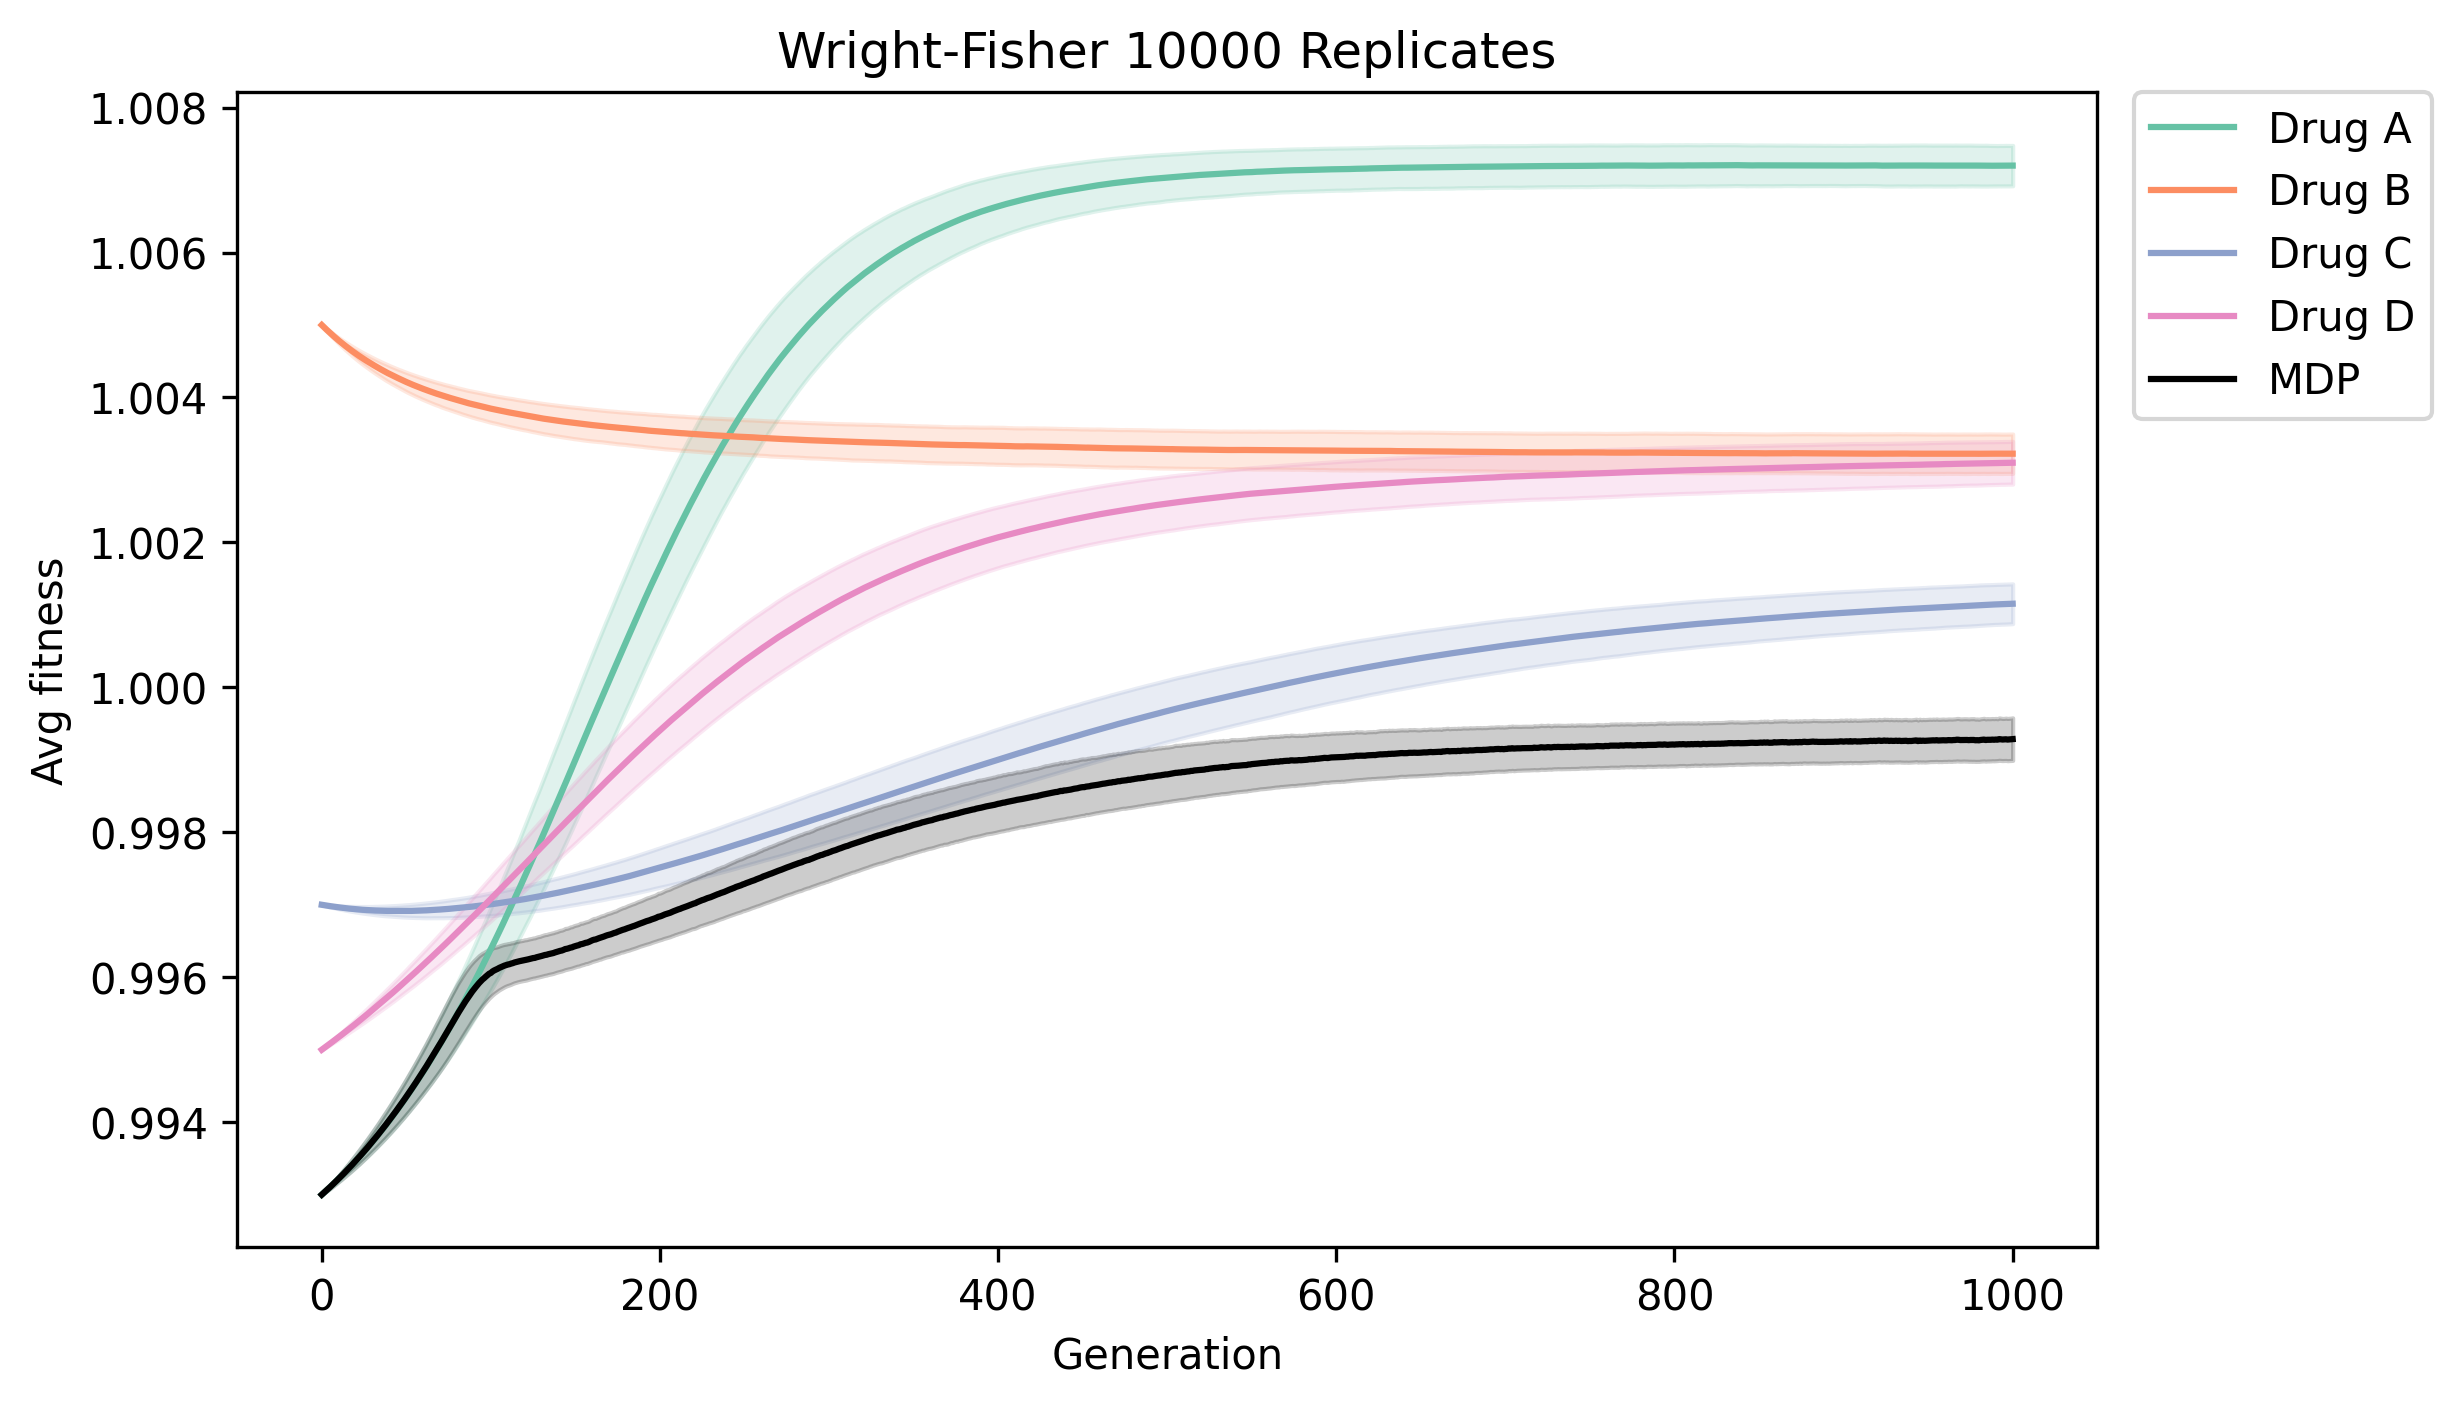

In [33]:
# plot
plt.figure(figsize=(8,5), dpi=300)
drug_names = ['A','B','C','D']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 'black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP"]

for i in range(len(actions)+1):
    plt.plot(t, mean_fit[i], color=colors[i], label=labels[i])
    plt.fill_between(t,
                     mean_fit[i]-std_fit[i],
                     mean_fit[i]+std_fit[i],
                     color=colors[i], alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Avg fitness")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title(f"Wright-Fisher {n_reps} Replicates")
plt.show()

Global min: 0.988 Global max: 1.009


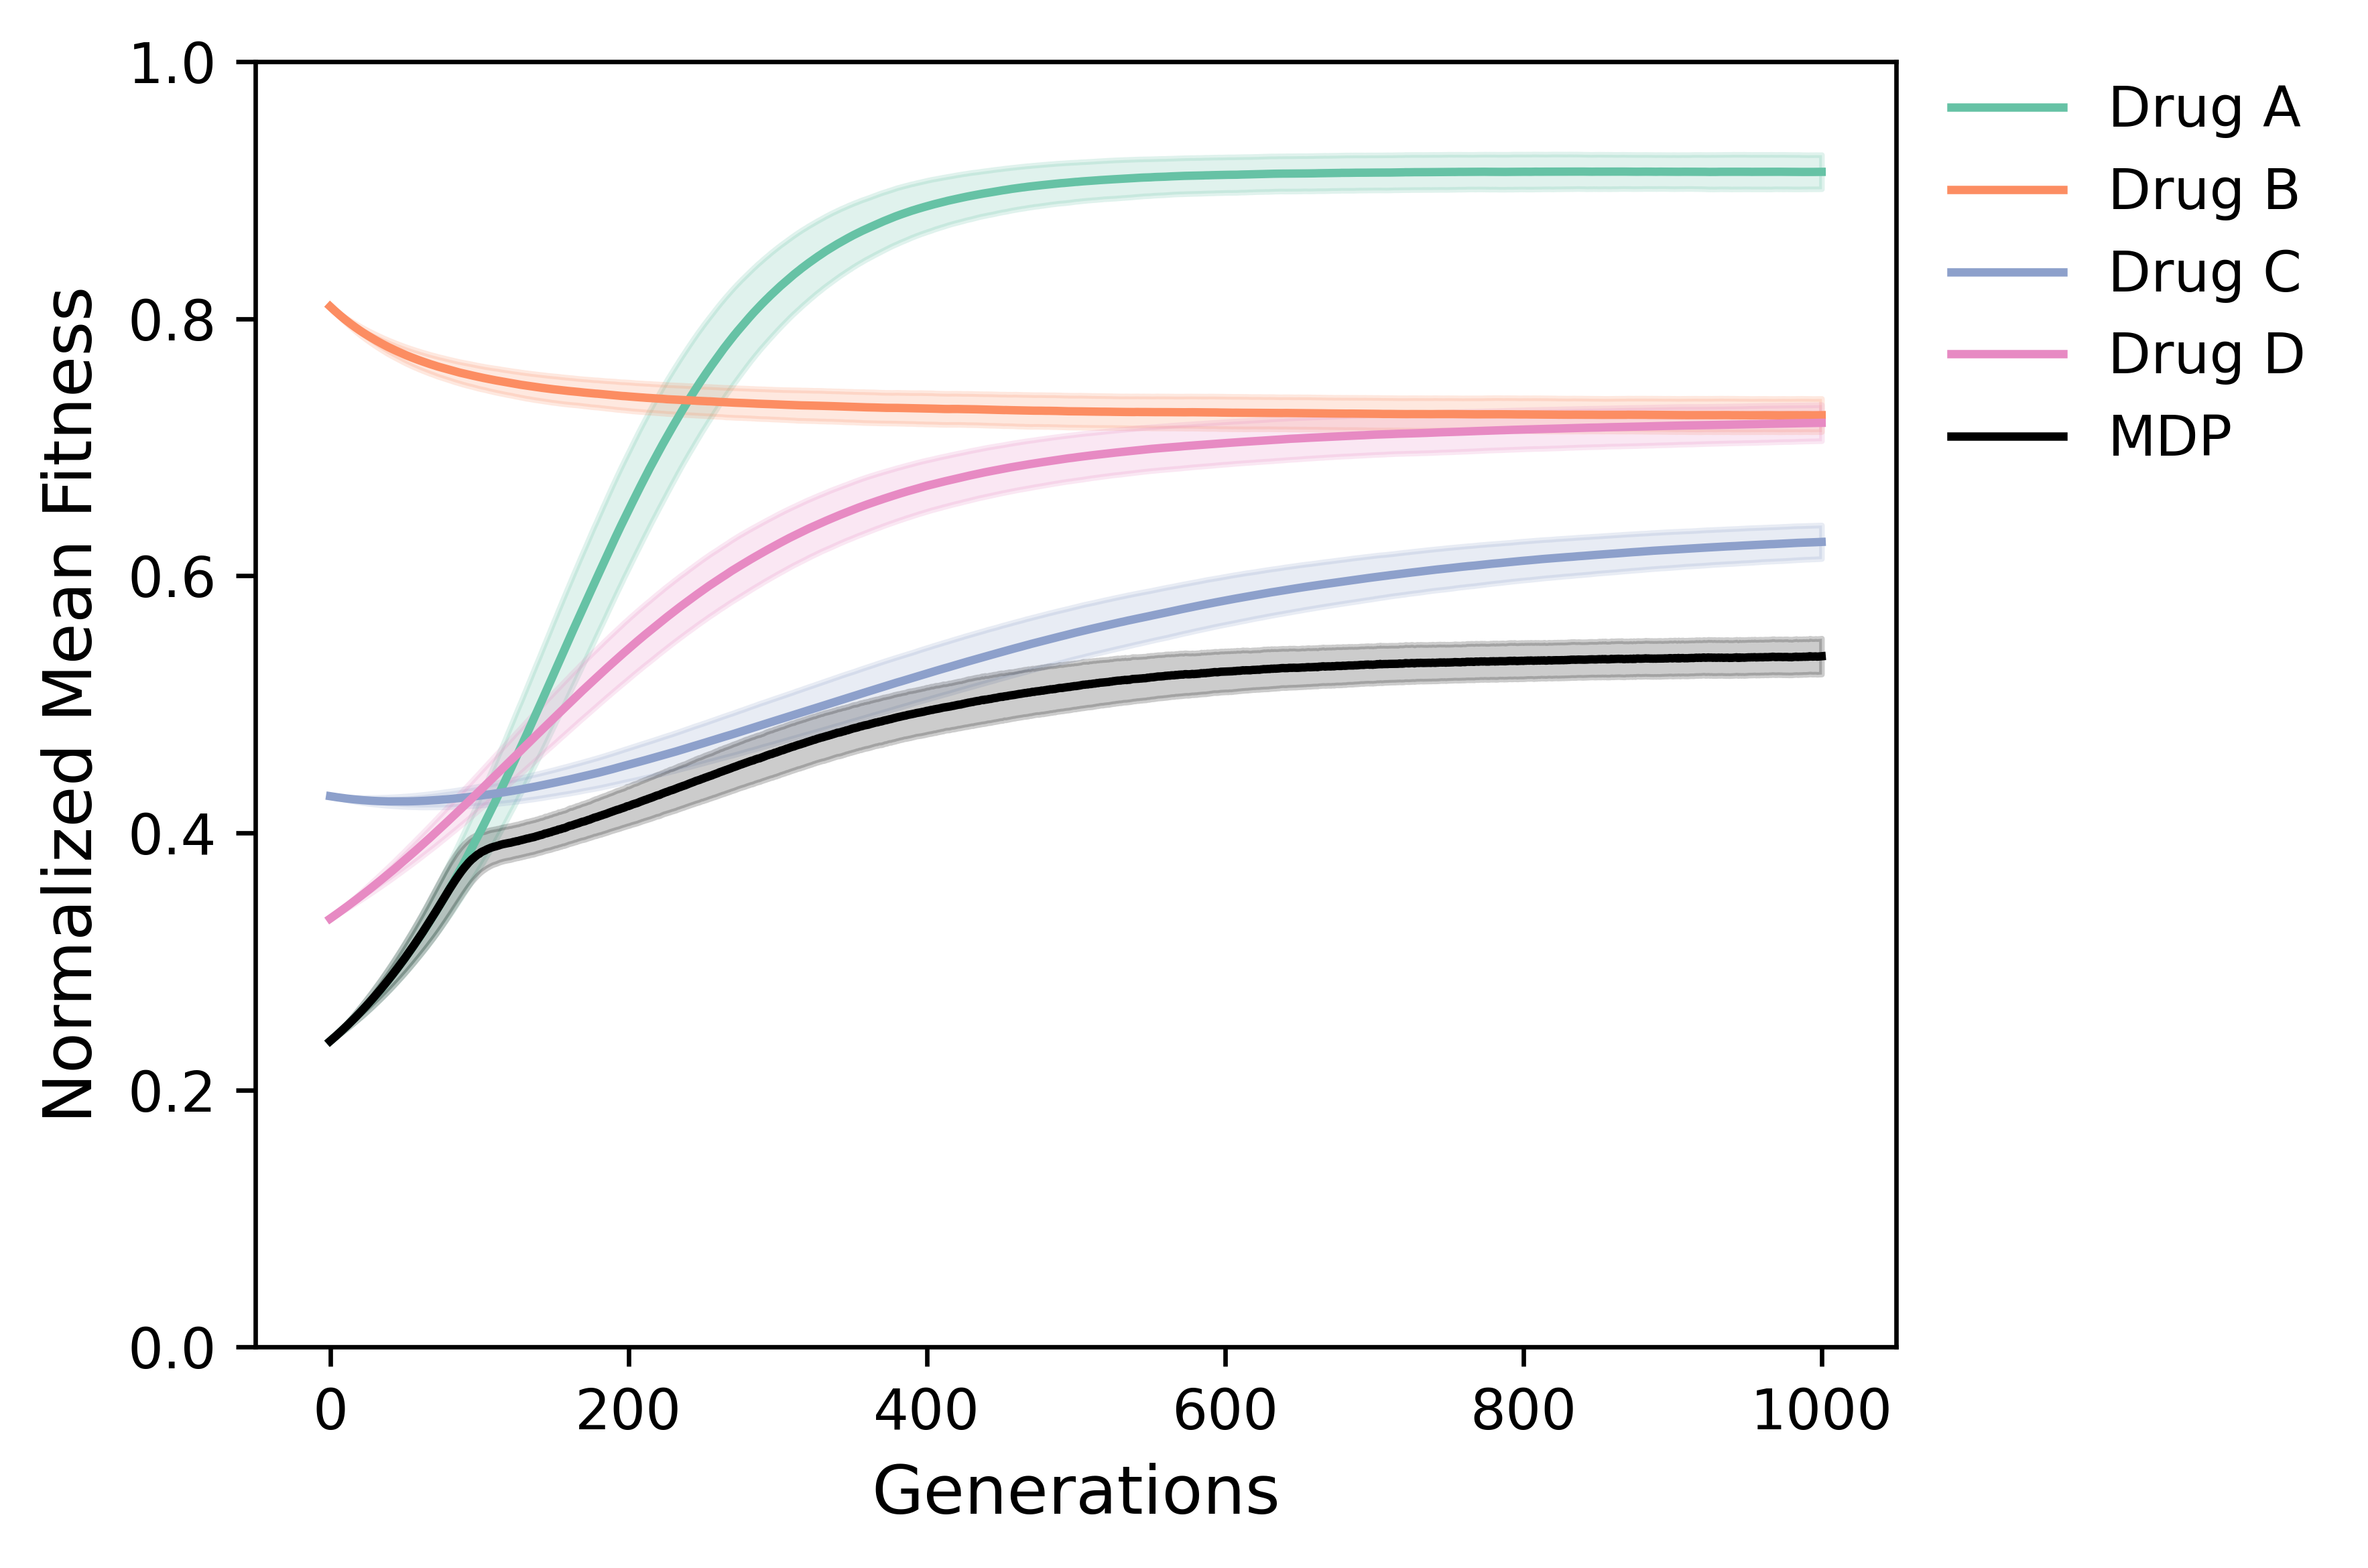

In [68]:
# collect all fitness values
all_fits = np.concatenate(list(map(np.array, drug_lists.values())))
global_min = all_fits.min()
global_max = all_fits.max()
print("Global min:", global_min, "Global max:", global_max)

# normalize mean_fit and std_fit by min-max scaling
mean_fit_norm = (mean_fit - global_min) / (global_max - global_min)
std_fit_norm  = std_fit / (global_max - global_min)   # scale std by same denominator

# --- plot ---
#plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)
plt.figure(figsize=(6,4), dpi=600)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 'black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP"]

for i in range(len(actions)+1):
    m = mean_fit_norm[i]
    s = std_fit_norm[i]
    plt.plot(t, m, color=colors[i], label=labels[i])
    plt.ylim(0,1)
    plt.fill_between(t, m - s, m + s, color=colors[i], alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
#plt.title(f"Wright–Fisher {n_reps} Replicates (min–max normalized)")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0,frameon=False)
plt.tight_layout()
plt.show()


In [61]:
import itertools

# ---------- ordered pairs (A→B and B→A are distinct) ----------
pairs = list(itertools.combinations(actions, 2))   # len = 6 for 4 drugs
pair_labels = [f"Drug {drug_names[a]}↔{drug_names[b]}" for a, b in pairs]

# ---------- alternating picker (no change to run_wf) ----------
def make_alt_picker_first(a, b, block_len=1):
    """Return picker(freq) that yields A→B→A→B… in blocks of length `block_len`."""
    counter = {'i': 0}
    def picker(_freq, a=a, b=b, block_len=block_len):
        blk = counter['i'] // block_len
        counter['i'] += 1
        return a if (blk % 2 == 0) else b
    return picker

# ---------- run the 6 A↔B policies ----------
n_pairs = len(pairs)
all_fit_two = np.zeros((n_pairs + 1, n_reps, t_step + 1))  # extra row for MDP

for p_idx, (a, b) in enumerate(pairs):
    for r in range(n_reps):
        # fresh picker per replicate to avoid counter leakage
        alt_picker = make_alt_picker_first(a, b, block_len=1)  # set block_len>1 for A…A B…B
        all_fit_two[p_idx, r], _, _ = run_wf(alt_picker)

In [62]:
from matplotlib.colors import to_rgb, to_hex

# --- helpers for pair colors (gamma-corrected blend) ---
single_color = {'A':'#66c2a5','B':'#fc8d62','C':'#8da0cb','D':'#e78ac3'}

def blend_hex(c1, c2, w=0.5, gamma=2.2):
    r1,g1,b1 = to_rgb(c1); r2,g2,b2 = to_rgb(c2)
    r1,g1,b1 = r1**gamma, g1**gamma, b1**gamma
    r2,g2,b2 = r2**gamma, g2**gamma, b2**gamma
    rl = (1-w)*r1 + w*r2; gl = (1-w)*g1 + w*g2; bl = (1-w)*b1 + w*b2
    return to_hex((rl**(1/gamma), gl**(1/gamma), bl**(1/gamma)))

def color_for_pair(a_idx, b_idx, w=0.5):
    na, nb = drug_names[a_idx], drug_names[b_idx]  # e.g., 'A','B'
    return blend_hex(single_color[na], single_color[nb], w=w)

# Build colors to match your `pairs` and `pair_labels`
pair_colors = [color_for_pair(a, b, w=0.5) for (a, b) in pairs]   # 6 colors


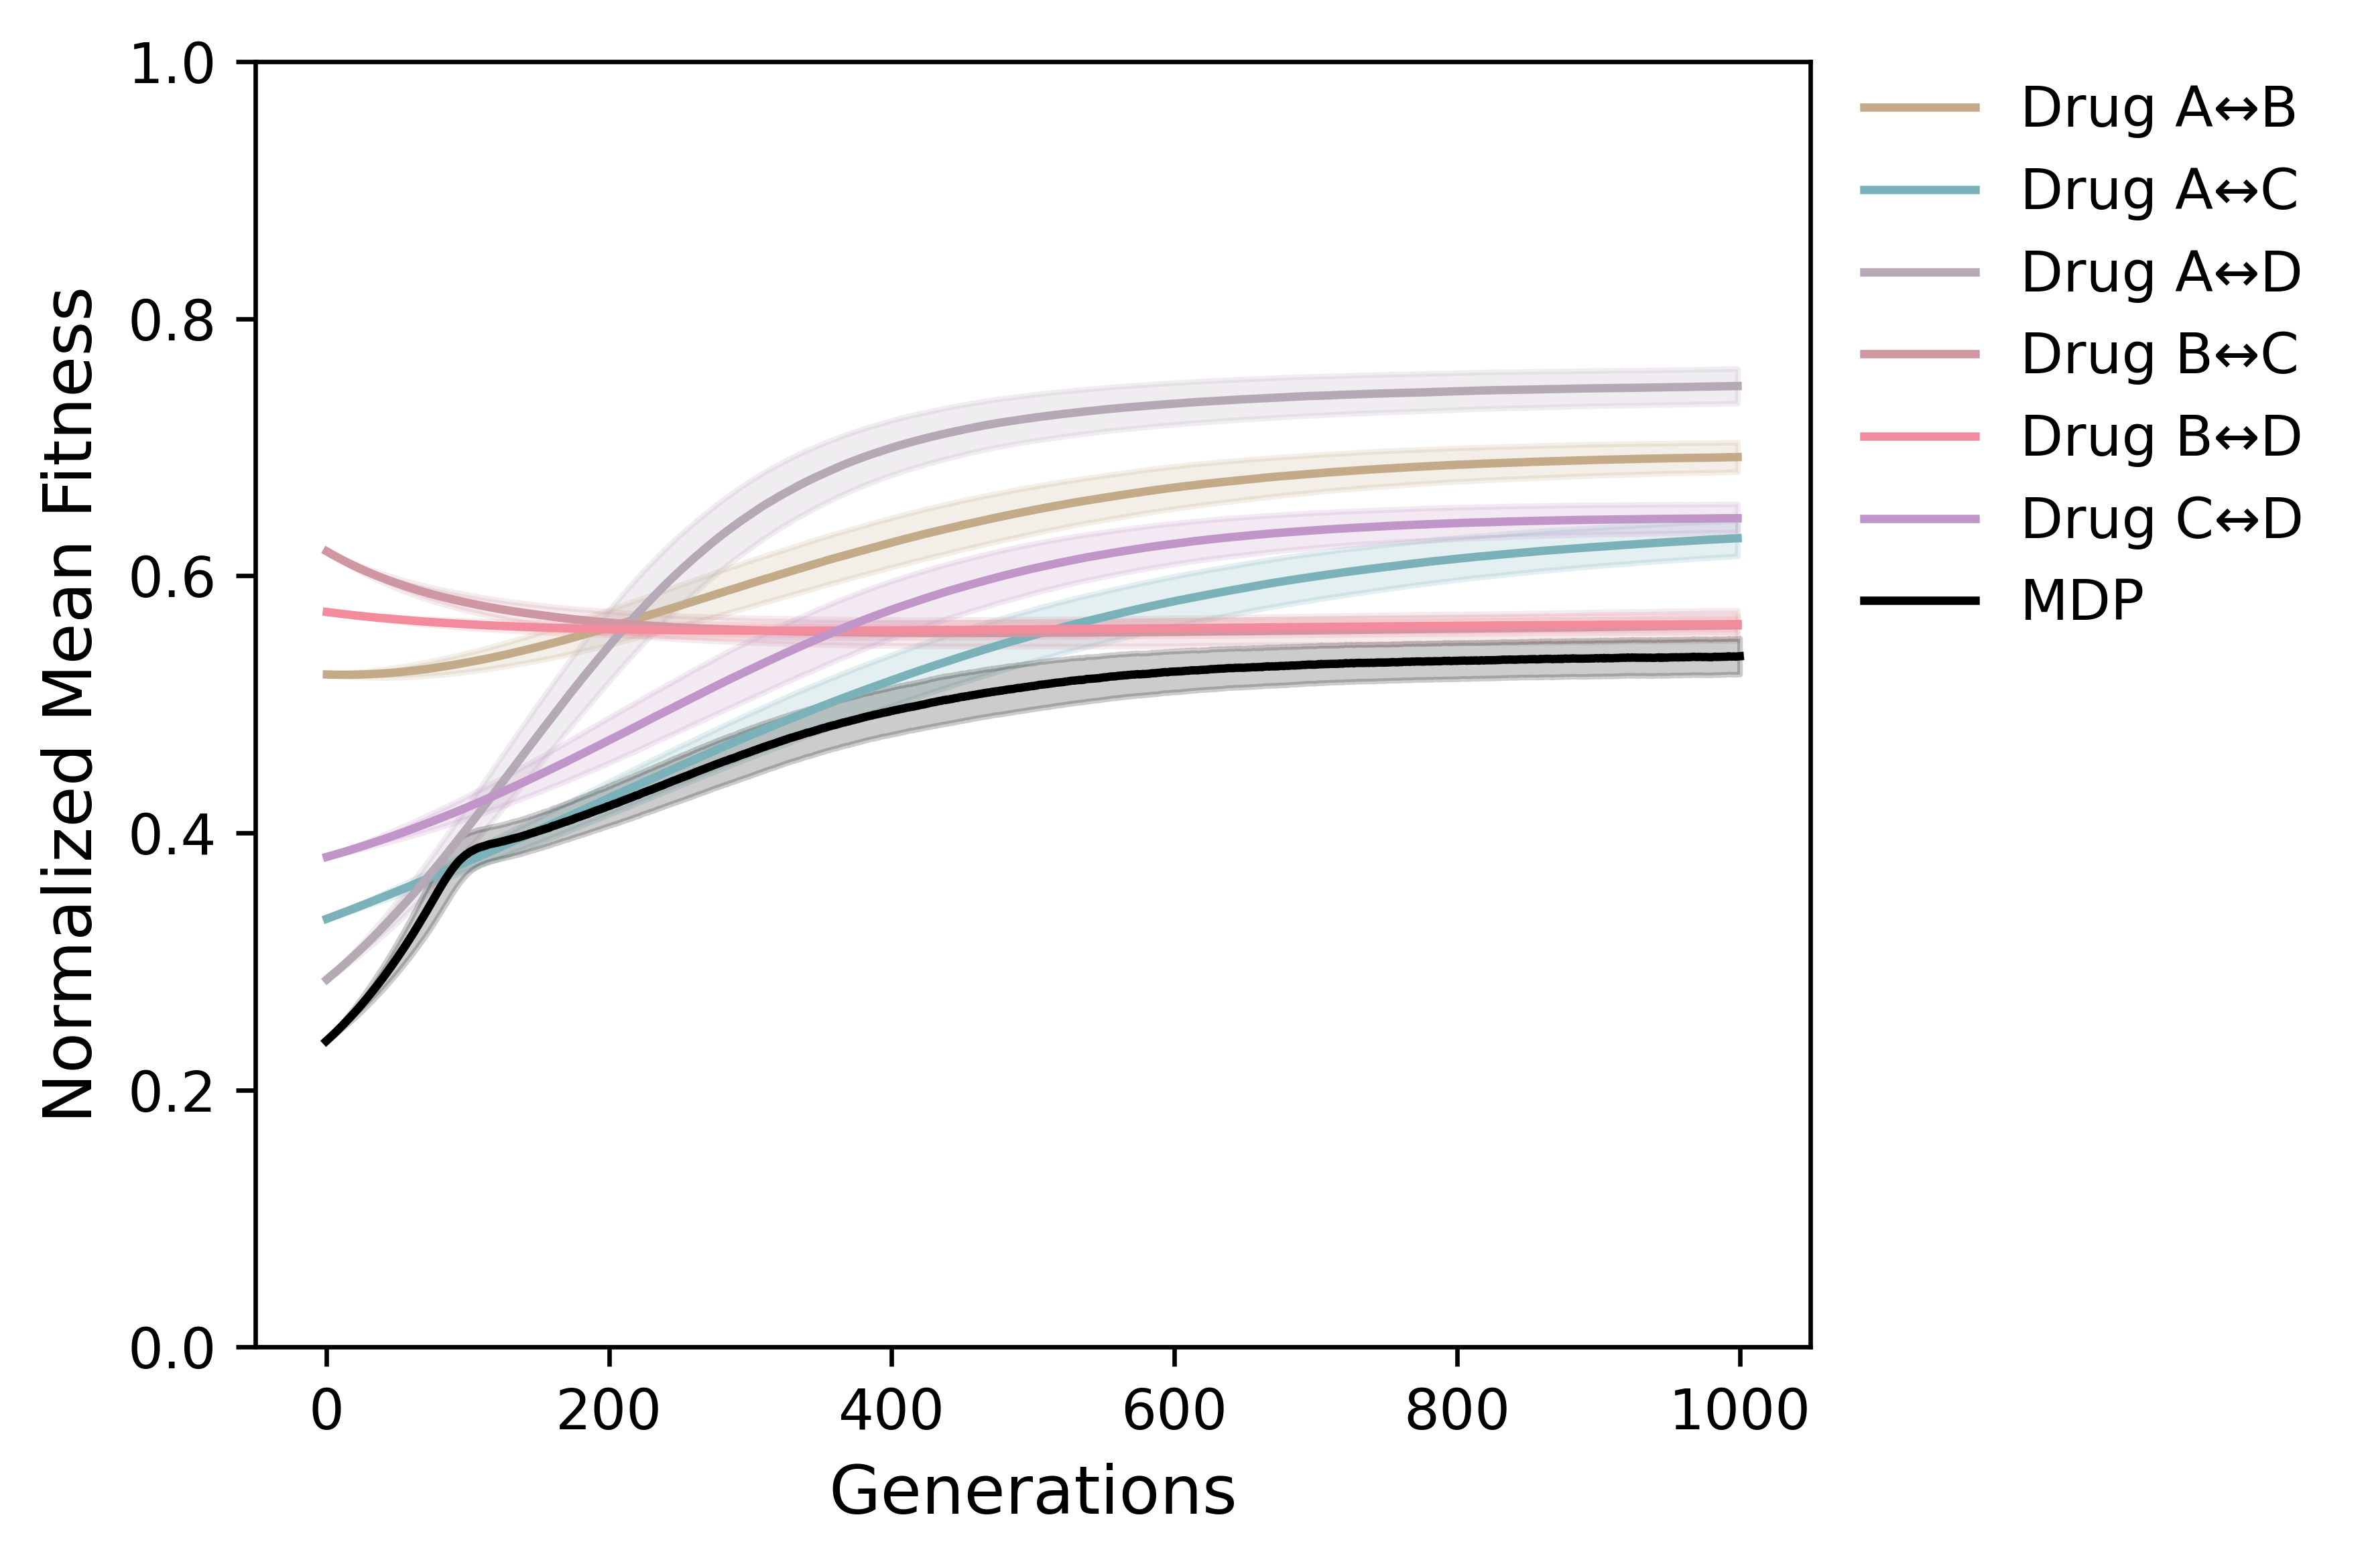

In [67]:
# all_fit_two: (n_pairs+1, n_reps, T); last row = MDP copied from all_fit[-1]
P, R, T = all_fit_two.shape
n_pairs = P - 1
T_even  = (T // 2) * 2

# --- 2-gen average ONLY for the pairs (exclude the last MDP row) ---
two_cycle = all_fit_two[:n_pairs, :, :T_even].reshape(n_pairs, R, T_even//2, 2).mean(axis=3)
mean_pairs = two_cycle.mean(axis=1)               # (n_pairs, T_even/2)
std_pairs  = two_cycle.std(axis=1)                # (n_pairs, T_even/2)

# --- MDP stays per-generation (no 2-gen averaging) ---
mdp_mean = mean_fit_norm[-1]
mdp_std  = std_fit_norm[-1]

# --- normalize everything with your existing global_min/global_max ---
den = max(global_max - global_min, 1e-12)
mean_pairs_norm = (mean_pairs - global_min) / den
std_pairs_norm  =  std_pairs / den

# --- time axes: pairs use 2-gen midpoints; MDP uses original t ---
t2 = t[:T_even].reshape(-1, 2).mean(axis=1)       # (T_even/2,)

# ===== plot: pairs (2-gen averaged) vs MDP (original) =====
#tab = plt.cm.tab20.colors

#plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)
plt.figure(figsize=(6,4), dpi=600)

# pairs
for i in range(n_pairs):
    m, s = mean_pairs_norm[i], std_pairs_norm[i]
    col  = pair_colors[i]
    plt.plot(t2, m, color=col, label=pair_labels[i])
    # comment next line if you want means only:
    plt.fill_between(t2, m - s, m + s, color=col, alpha=0.2)

# MDP (no averaging)
plt.plot(t, mdp_mean, color="black", label="MDP")
# comment next line if you want means only:
plt.fill_between(t, mdp_mean - mdp_std, mdp_mean + mdp_std,
                 color="black", alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()


policy grid

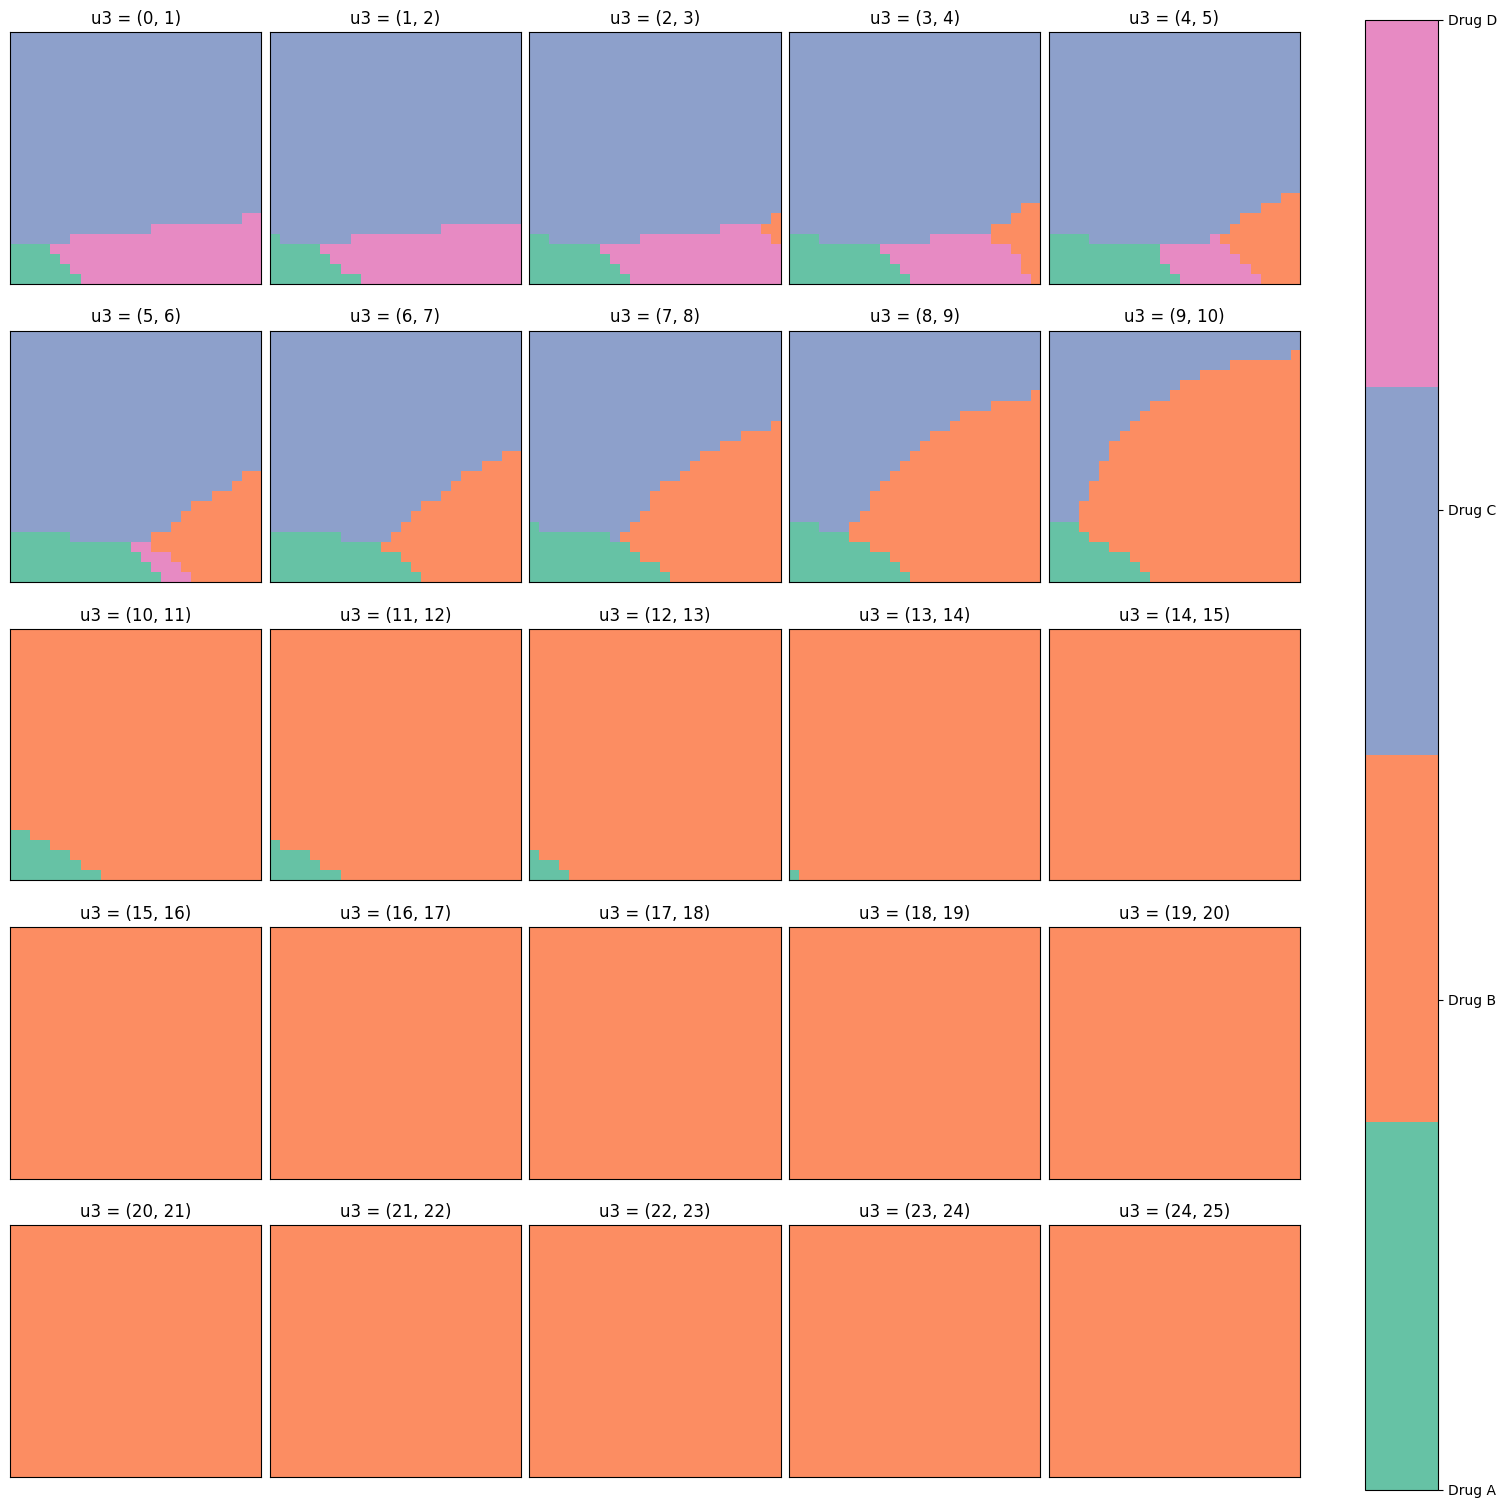

In [15]:
drug_names = ['A','B','C','D']
cmap = ListedColormap(['#66c2a5','#fc8d62','#8da0cb','#e78ac3'])

ncols = 5
nrows = int(np.ceil(L / ncols))   

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), constrained_layout=True)
for k in range(L):
    ax = axs.flat[k]
    im = ax.imshow(
        policy_grid[:, :, k].T,
        origin='lower',
        cmap=cmap,
        vmin=0, vmax=len(drug_names)-1
    )
    ax.set_title(f"u3 = ({k}, {k+1})")
    ax.set_xticks([]); ax.set_yticks([])

# make a colorbar with one tick per drug
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), ticks=range(len(drug_names)))
cbar.set_ticklabels([f"Drug {n}" for n in drug_names])
#cbar.set_label("Chosen drug")

plt.show()


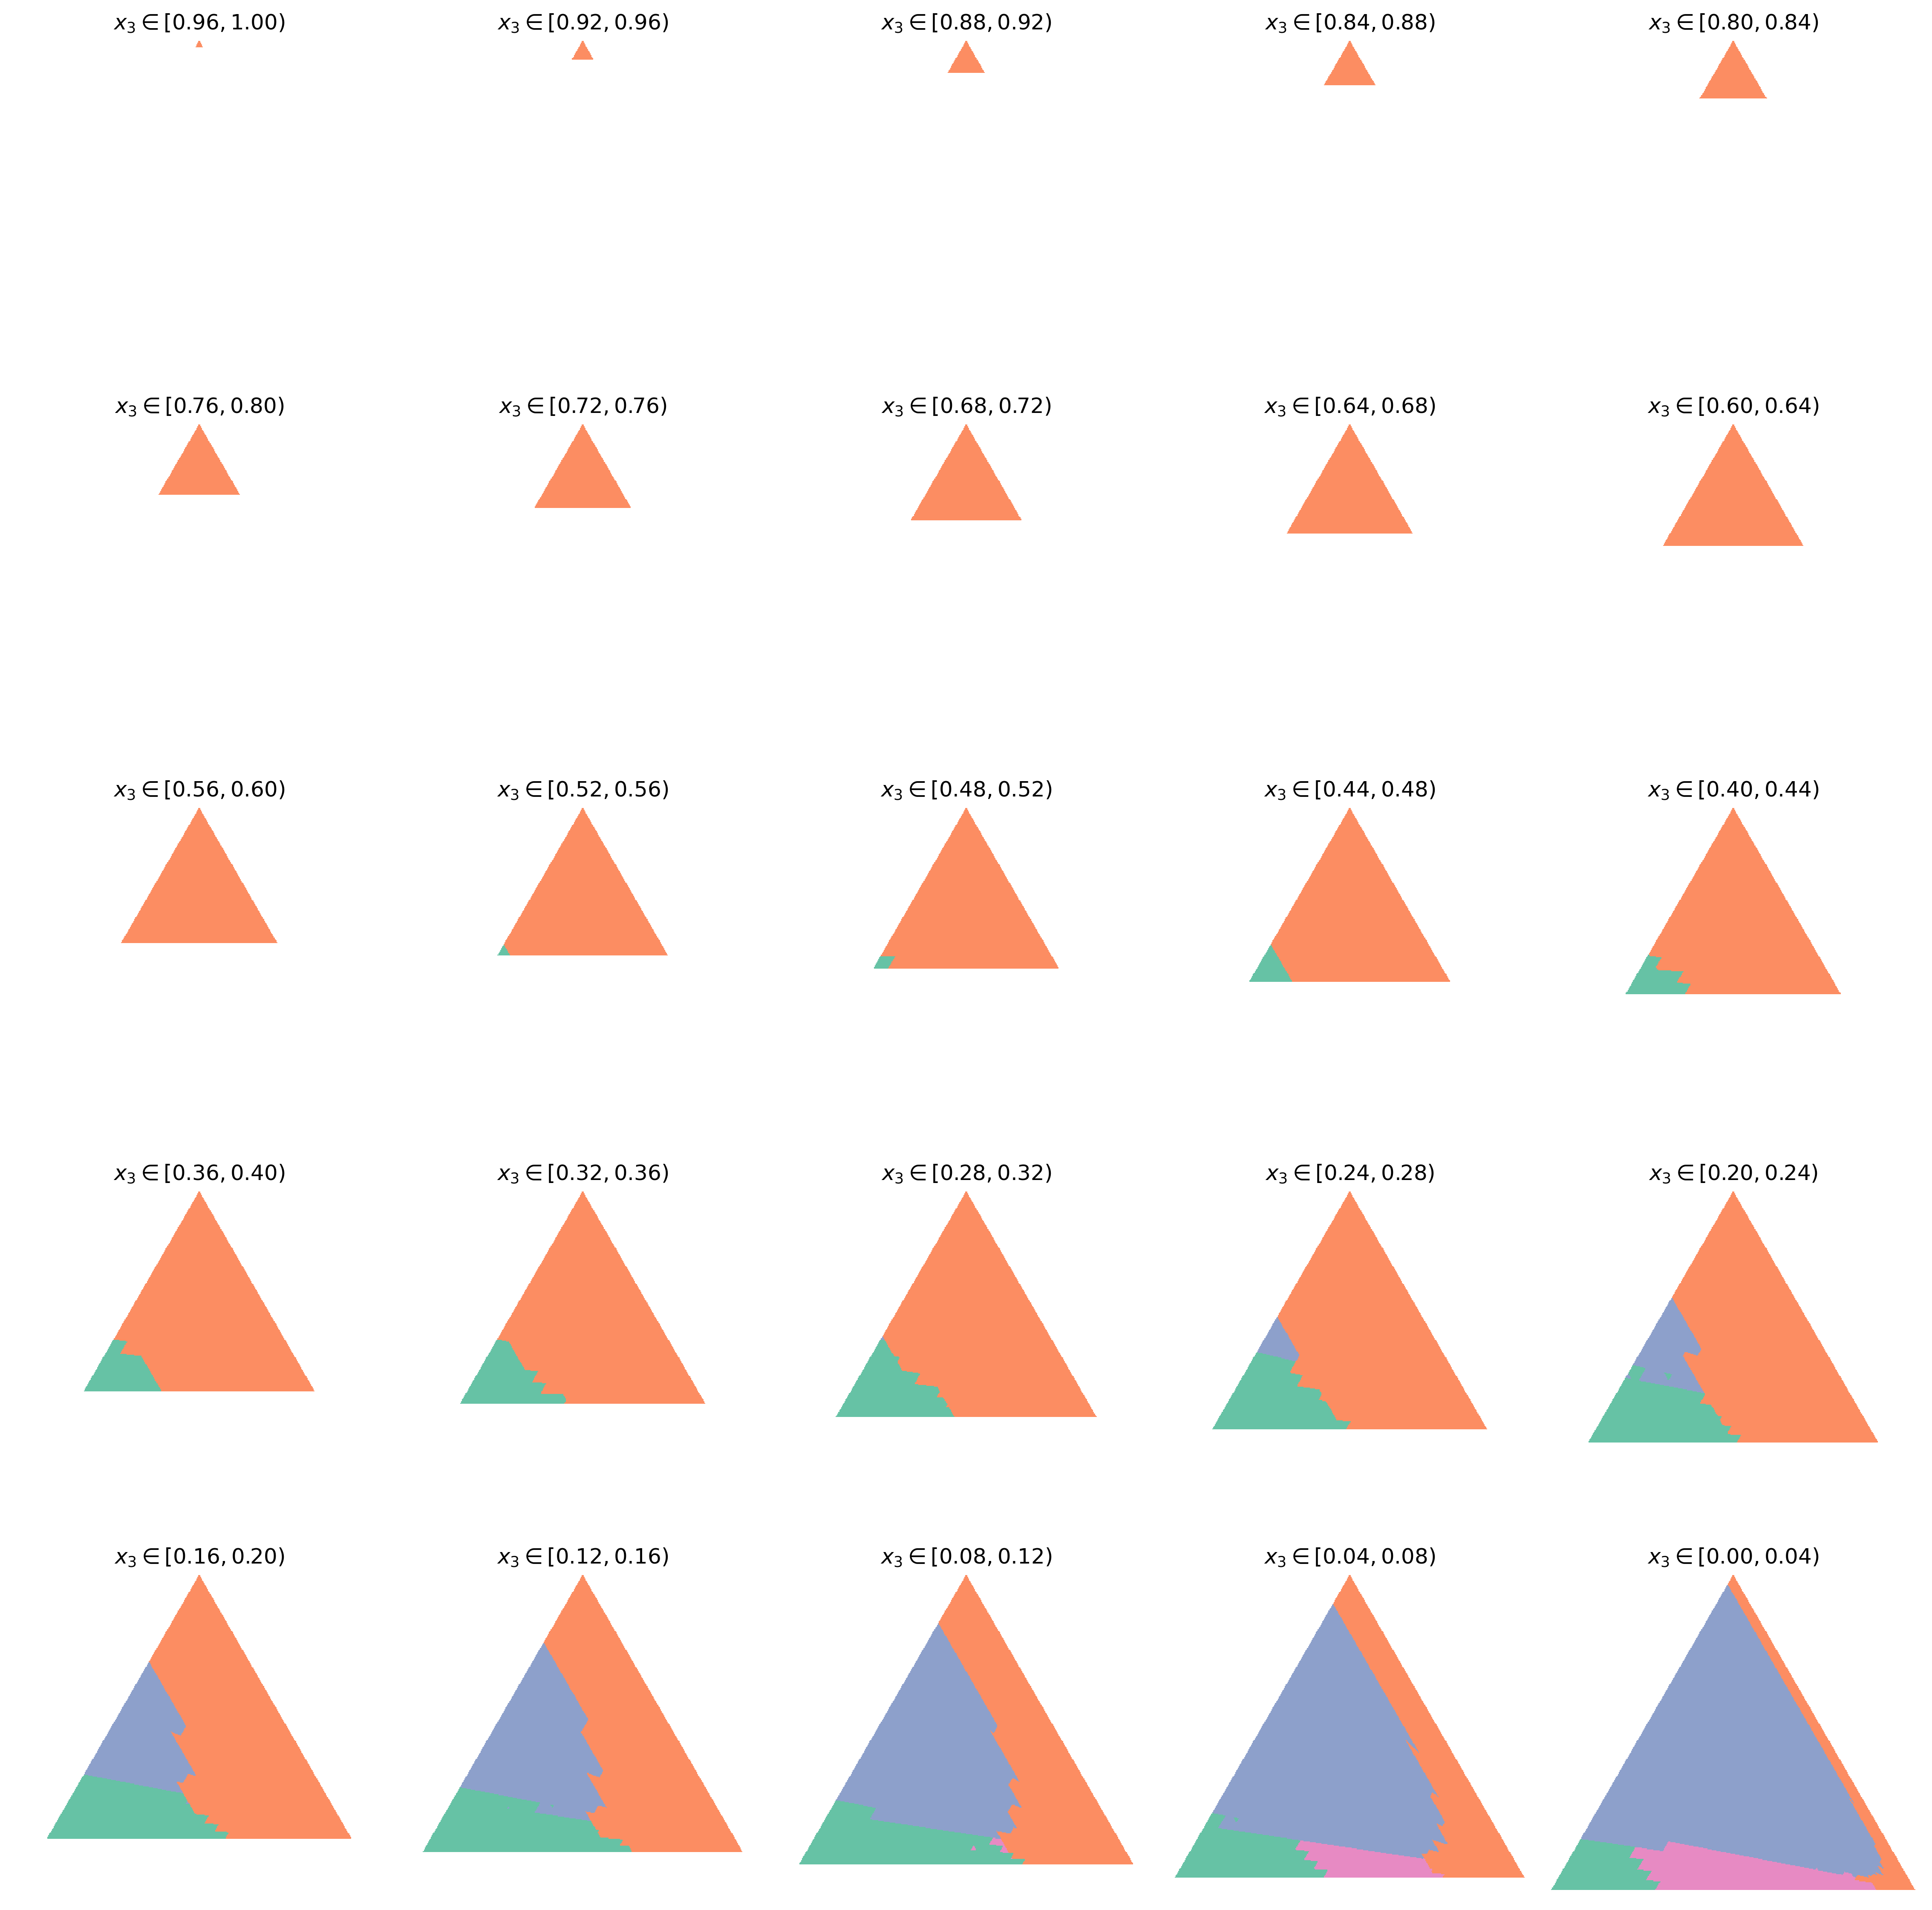

In [36]:
# ===== colormap =====
drug_names = ['A','B','C','D']
cmap = ListedColormap(['#66c2a5','#fc8d62','#8da0cb','#e78ac3']).copy()
cmap.set_bad(alpha=0.0)
norm = BoundaryNorm(np.arange(-0.5, len(drug_names)+0.5, 1), ncolors=len(drug_names))

# ===== unit simplex geometry =====
unit_h = np.sqrt(3)/2.0
v0 = np.array([0.0, 0.0])        # x0 = 1 (left)
v1 = np.array([1.0, 0.0])        # x1 = 1 (right)
v2 = np.array([0.5, unit_h])     # x2 = 1 (TOP)

# barycentric w.r.t. unit triangle (v0,v1,v2)
def barycentric_unit(X, Y):
    # For v0=(0,0), v1=(1,0), v2=(1/2,√3/2)
    b2 = Y / unit_h
    b1 = X - 0.5 * b2
    b0 = 1.0 - b1 - b2
    return b0, b1, b2

# map (x1,x2,x3) -> nearest (u1,u2,u3) grid indices
def u_indices_from_x123(x1, x2, x3, a, L):
    u1 = x1
    den1 = np.maximum(1.0 - u1, 1e-12)
    u2 = x2 / den1
    den2 = np.maximum((1.0 - u1)*(1.0 - u2), 1e-12)
    u3 = x3 / den2
    ui = np.clip(np.round((u1 - a/2)/a).astype(int), 0, L-1)
    uj = np.clip(np.round((u2 - a/2)/a).astype(int), 0, L-1)
    uk = np.clip(np.round((u3 - a/2)/a).astype(int), 0, L-1)
    return ui, uj, uk

# ===== slicing & plotting =====
n_slices = L
bins = np.linspace(0.0, 1.0, n_slices+1)  # x3 bins
ncols = 5
nrows = int(np.ceil(n_slices / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*3.0),
                        constrained_layout=True, dpi=300)

# raster grid in the unit-frame (shared by all panels)
W = 420
H = int(round(W * unit_h))
xs = np.linspace(0.0, 1.0, W)
ys = np.linspace(0.0, unit_h, H)
XX, YY = np.meshgrid(xs, ys)

axes_flat = axs.ravel()
last_im = None
tol = 1e-12

for pane in range(n_slices):
    ax = axes_flat[pane]

    # HIGH -> LOW x3 so top row are smallest triangles
    lo = bins[n_slices-1-pane]
    hi = bins[n_slices-1-pane + 1]
    x3_mid = 0.5*(lo + hi)
    s = 1.0 - x3_mid                       # slice scale
    if s <= 0:
        ax.axis('off'); continue

    # barycentrics of each unit pixel
    b0p, b1p, b2p = barycentric_unit(XX, YY)

    # pixel belongs to the slice triangle (apex-fixed) iff b2' >= 1 - s
    inside = (b0p >= -tol) & (b1p >= -tol) & (b2p >= -tol) & (b2p >= 1.0 - s - tol)

    # slice coordinates for inside pixels:
    # x0 = b0', x1 = b1', x2 = b2' - (1 - s), x3 = 1 - s
    x1 = b1p
    x2 = np.maximum(b2p - (1.0 - s), 0.0)  # clamp tiny negatives
    x3 = np.full_like(x1, 1.0 - s)

    # map to u-grid & fetch policy
    ui, uj, uk = u_indices_from_x123(x1, x2, x3, a, L)
    img = np.full((H, W), np.nan, dtype=float)
    valid = inside & (ui>=0) & (ui<L) & (uj>=0) & (uj<L) & (uk>=0) & (uk<L)
    img[valid] = policy_grid[ui[valid], uj[valid], uk[valid]].astype(float)

    # draw raster in the unit frame (only slice area is colored)
    im = ax.imshow(img, origin='lower', interpolation='nearest',
                   extent=(0.0, 1.0, 0.0, unit_h), cmap=cmap, norm=norm)
    last_im = im

    # outlines: unit simplex (light) + slice triangle (black)
    #unit_tri = np.array([[0,0],[1,0],[0.5,unit_h],[0,0]])
    #ax.plot(unit_tri[:,0], unit_tri[:,1], color='0.8', lw=0.8)

    t0 = (1.0 - s)*v2 + s*v0
    t1 = (1.0 - s)*v2 + s*v1
    t2 = v2
    slice_tri = np.vstack([t0, t1, t2, t0])
    #ax.plot(slice_tri[:,0], slice_tri[:,1], 'k-', lw=1.2)

    ax.set_xlim(0.0, 1.0); ax.set_ylim(0.0, unit_h); ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.set_title(rf"$x_3 \in [{lo:.2f}, {hi:.2f})$")

# turn off extras
for t in range(n_slices, nrows*ncols):
    axes_flat[t].axis('off')

# optional colorbar
# cbar = fig.colorbar(last_im, ax=axs.ravel().tolist(), ticks=range(len(drug_names)))
# cbar.set_ticklabels([f"Drug {n}" for n in drug_names])
# cbar.outline.set_visible(False)

plt.show()


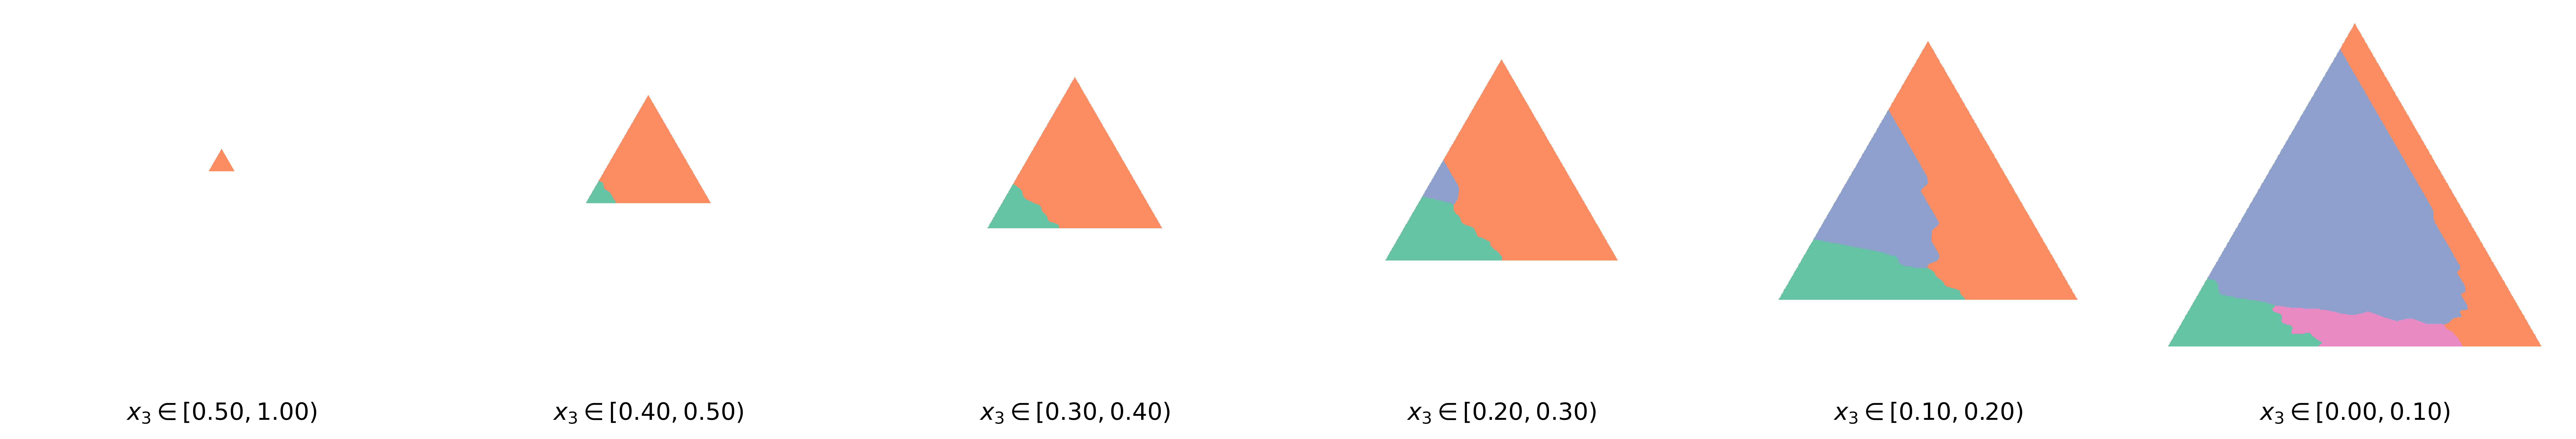

In [59]:
# ===== colormap =====
drug_names = ['A','B','C','D']
cmap = ListedColormap(['#66c2a5','#fc8d62','#8da0cb','#e78ac3']).copy()
cmap.set_bad(alpha=0.0)
norm = BoundaryNorm(np.arange(-0.5, len(drug_names)+0.5, 1), ncolors=len(drug_names))

# ===== unit simplex geometry =====
unit_h = np.sqrt(3)/2.0
v0 = np.array([0.0, 0.0])        # x0 = 1 (left)
v1 = np.array([1.0, 0.0])        # x1 = 1 (right)
v2 = np.array([0.5, unit_h])     # x2 = 1 (TOP)

def barycentric_unit(X, Y):
    b2 = Y / unit_h
    b1 = X - 0.5 * b2
    b0 = 1.0 - b1 - b2
    return b0, b1, b2

# --- continuous u-coordinates (not rounded) ---
def ucoords_from_x123(x1, x2, x3, a, L):
    u1 = x1
    den1 = np.maximum(1.0 - u1, 1e-12)
    u2 = x2 / den1
    den2 = np.maximum((1.0 - u1) * (1.0 - u2), 1e-12)
    u3 = x3 / den2

    # convert to lattice coordinates in [0, L-1], *not* rounded
    uu1 = np.clip((u1 - a/2) / a, 0.0, L - 1 - 1e-9)
    uu2 = np.clip((u2 - a/2) / a, 0.0, L - 1 - 1e-9)
    uu3 = np.clip((u3 - a/2) / a, 0.0, L - 1 - 1e-9)
    return uu1, uu2, uu3

def trilinear_policy(policy_grid, uu1, uu2, uu3):
    """
    Trilinear soft-vote of discrete policies at fractional lattice coords uu*.
    Returns the argmax class (0..3) per pixel, vectorized.
    """
    L = policy_grid.shape[0]
    i0 = np.floor(uu1).astype(int); j0 = np.floor(uu2).astype(int); k0 = np.floor(uu3).astype(int)
    di = uu1 - i0; dj = uu2 - j0; dk = uu3 - k0

    i1 = np.clip(i0 + 1, 0, L-1); j1 = np.clip(j0 + 1, 0, L-1); k1 = np.clip(k0 + 1, 0, L-1)

    # 8 corner weights
    w000 = (1-di)*(1-dj)*(1-dk)
    w100 = di*(1-dj)*(1-dk)
    w010 = (1-di)*dj*(1-dk)
    w110 = di*dj*(1-dk)
    w001 = (1-di)*(1-dj)*dk
    w101 = di*(1-dj)*dk
    w011 = (1-di)*dj*dk
    w111 = di*dj*dk

    # gather corner labels
    p000 = policy_grid[i0, j0, k0]
    p100 = policy_grid[i1, j0, k0]
    p010 = policy_grid[i0, j1, k0]
    p110 = policy_grid[i1, j1, k0]
    p001 = policy_grid[i0, j0, k1]
    p101 = policy_grid[i1, j0, k1]
    p011 = policy_grid[i0, j1, k1]
    p111 = policy_grid[i1, j1, k1]

    # soft vote over the 4 drugs
    n_classes = 4
    votes = np.zeros((n_classes,) + uu1.shape, dtype=float)
    for c in range(n_classes):
        votes[c] = (
            w000*(p000==c) + w100*(p100==c) + w010*(p010==c) + w110*(p110==c) +
            w001*(p001==c) + w101*(p101==c) + w011*(p011==c) + w111*(p111==c)
        )
    return np.argmax(votes, axis=0)

# ===== slicing & plotting =====
n_slices = 6
bins = np.array([0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 1.00]) 
ncols = 6
nrows = int(np.ceil(n_slices / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*3.0),
                        constrained_layout=True, dpi=600)

# raster grid in the unit-frame (shared by all panels)
W = 520  # a bit higher res helps
H = int(round(W * unit_h))
xs = np.linspace(0.0, 1.0, W)
ys = np.linspace(0.0, unit_h, H)
XX, YY = np.meshgrid(xs, ys)

axes_flat = axs.ravel()
last_im = None
tol = 1e-12

for pane in range(n_slices):
    ax = axes_flat[pane]

    # HIGH -> LOW x3 so top row are smallest triangles
    lo = bins[n_slices-1-pane]
    hi = bins[n_slices-1-pane + 1]
    x3_mid = 0.5*(lo + hi)
    s = 1.0 - x3_mid
    if s <= 0:
        ax.axis('off'); continue

    # center the slice box inside the panel
    # compute a centered extent for the slice (same padding left/right & top/bottom)
    xpad = (1.0 - s) / 2.0
    ypad = unit_h * (1.0 - s) / 2.0
    extent_centered = (xpad, 1.0 - xpad, ypad, unit_h - ypad)


    # barycentrics of each unit pixel
    b0p, b1p, b2p = barycentric_unit(XX, YY)

    # pixel belongs to the slice triangle (apex-fixed): b2 >= 1 - s
    inside = (b0p >= -tol) & (b1p >= -tol) & (b2p >= -tol) & (b2p >= 1.0 - s - tol)

    # slice coords: x0=b0, x1=b1, x2=b2-(1-s), x3=1-s
    x1 = b1p
    x2 = np.maximum(b2p - (1.0 - s), 0.0)
    x3 = np.full_like(x1, 1.0 - s)

    # --- smooth (trilinear) policy lookup ---
    uu1, uu2, uu3 = ucoords_from_x123(x1, x2, x3, a, L)
    img = np.full((H, W), np.nan, dtype=float)
    if inside.any():
        policy_soft = trilinear_policy(policy_grid, uu1, uu2, uu3)
        img[inside] = policy_soft[inside].astype(float)

    im = ax.imshow(
    img, origin='lower', interpolation='none',
    extent=extent_centered, cmap=cmap, norm=norm
    )

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, unit_h)
    ax.set_aspect('equal')

    last_im = im

    #ax.set_xlim(0.0, 1.0); ax.set_ylim(0.0, unit_h); ax.set_aspect('equal')
    ax.set_xticks([]); ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)
    #ax.set_title(rf"$x_3 \in [{lo:.2f}, {hi:.2f})$")
    label = rf"$x_3 \in [{lo:.2f}, {hi:.2f})$"
    ax.set_xlabel(label, fontsize=12, labelpad=5)        # puts text below the triangle
    ax.tick_params(bottom=False, labelbottom=False,     # keep the plot clean
                left=False,   labelleft=False)
    ax.xaxis.set_label_coords(0.5, -0.08)  # center, slightly below the default


# turn off extras
for t in range(n_slices, nrows*ncols):
    axes_flat[t].axis('off')

plt.show()
